# Human Activity Prediction 

### Libraries 

In [106]:
## Modelling
library(caret); library(rattle); library(randomForest); library(e1071); library(forecast)
## Data processing/visualization
library(dplyr); library(ggplot2); library(rattle)

#### Getting the data
Downloading

In [93]:
train_URL = "https://d396qusza40orc.cloudfront.net/predmachlearn/pml-training.csv"
test_URL = "https://d396qusza40orc.cloudfront.net/predmachlearn/pml-testing.csv"
download.file(train_URL, destfile = "./data/train.csv")
download.file(test_URL, destfile = "./data/test.csv")

Loading

In [94]:
train_raw = read.csv("./data/train.csv")
test_raw = read.csv("./data/test.csv")
head(train_raw)

X,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,...,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe
1,carlitos,1323084231,788290,05/12/2011 11:23,no,11,1.41,8.07,-94.4,...,0.03,0.00,-0.02,192,203,-215,-17,654,476,A
2,carlitos,1323084231,808298,05/12/2011 11:23,no,11,1.41,8.07,-94.4,...,0.02,0.00,-0.02,192,203,-216,-18,661,473,A
3,carlitos,1323084231,820366,05/12/2011 11:23,no,11,1.42,8.07,-94.4,...,0.03,-0.02,0.00,196,204,-213,-18,658,469,A
4,carlitos,1323084232,120339,05/12/2011 11:23,no,12,1.48,8.05,-94.4,...,0.02,-0.02,0.00,189,206,-214,-16,658,469,A
5,carlitos,1323084232,196328,05/12/2011 11:23,no,12,1.48,8.07,-94.4,...,0.02,0.00,-0.02,189,206,-214,-17,655,473,A
6,carlitos,1323084232,304277,05/12/2011 11:23,no,12,1.45,8.06,-94.4,...,0.02,-0.02,-0.03,193,203,-215,-9,660,478,A


In [95]:
dim(train_raw); dim(test_raw)

[1] 19622   160

[1]  20 160

## Data cleaning
There are lot of unnecessary variables, some of which are highly correlated.  
The 'raw_timestamp' is used to derive converted timestamp - 'cvtd_timestamp'  

I remove X, user_name, new_window, num_window to simplify the model further, and
raw_timestamp_part_1, raw_timestamp_part_2, cvtd_timestamp because our goal is to identify the class of activity and timeseries information has no significant role in assessing this. 

Looking for **missing** data 

In [96]:
missing = union(as.numeric(which(sapply(train_raw, function(x){mean(is.na(x))})>0.80)),
                as.numeric(which(sapply(train_raw, function(x){mean(x=="", na.rm = T)})>0.80)))
missing = union(missing, c(1,2,3,4,5,6,7))
missing

[1]  18  19  21  22  24  25  27  28  29  30  31  32  33  34  35  36  50  51
 [19]  52  53  54  55  56  57  58  59  75  76  77  78  79  80  81  82  83  93
 [37]  94  96  97  99 100 103 104 105 106 107 108 109 110 111 112 131 132 134
 [55] 135 137 138 141 142 143 144 145 146 147 148 149 150  12  13  14  15  16
 [73]  17  20  23  26  69  70  71  72  73  74  87  88  89  90  91  92  95  98
 [91] 101 125 126 127 128 129 130 133 136 139   1   2   3   4   5   6   7

Removing **zero** or **near-zero covariates**

In [97]:
nzv = nearZeroVar(train_pre_clean)
nzv

integer(0)

No output suggests all of the remaining covariates contribute significant information to modelling a predictve model.

**Cleaned** dataset

In [98]:
train_clean = train_raw[,-missing]
test_clean = test_raw[,-missing]
dim(train_clean); dim(test_clean)

[1] 19622    53

[1] 20 53

In [99]:
head(train_clean)

roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,...,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe
1.41,8.07,-94.4,3,0.00,0.00,-0.02,-21,4,22,...,0.03,0.00,-0.02,192,203,-215,-17,654,476,A
1.41,8.07,-94.4,3,0.02,0.00,-0.02,-22,4,22,...,0.02,0.00,-0.02,192,203,-216,-18,661,473,A
1.42,8.07,-94.4,3,0.00,0.00,-0.02,-20,5,23,...,0.03,-0.02,0.00,196,204,-213,-18,658,469,A
1.48,8.05,-94.4,3,0.02,0.00,-0.03,-22,3,21,...,0.02,-0.02,0.00,189,206,-214,-16,658,469,A
1.48,8.07,-94.4,3,0.02,0.02,-0.02,-21,2,24,...,0.02,0.00,-0.02,189,206,-214,-17,655,473,A
1.45,8.06,-94.4,3,0.02,0.00,-0.02,-21,4,21,...,0.02,-0.02,-0.03,193,203,-215,-9,660,478,A


## Modelling Random Forests classifier

splitting the training dataset into train and validation sets

In [100]:
inTrain = createDataPartition(train_clean$classe, p = 0.75, list = F)
training = train_clean[inTrain,]
validation = train_clean[-inTrain,]

#### Building classifier

In [101]:
train_control_params = trainControl(method="repeatedcv", number=10, repeats= 5)
mdl_rf = train(classe~., method = "rf", trControl=train_control_params, ntree = 10, data = training)

#### Evaluating the model on validation set

In [102]:
val_preds = predict(mdl_rf, newdata = validation) 

In [103]:
confusionMatrix(val_preds, validation$classe)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1394    8    0    0    0
         B    1  938    5    1    0
         C    0    2  845    7    3
         D    0    0    5  796    7
         E    0    1    0    0  891

Overall Statistics
                                          
               Accuracy : 0.9918          
                 95% CI : (0.9889, 0.9942)
    No Information Rate : 0.2845          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9897          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9993   0.9884   0.9883   0.9900   0.9889
Specificity            0.9977   0.9982   0.9970   0.9971   0.9998
Pos Pred Value         0.9943   0.9926   0.9860   0.9851   0.9989
Neg Pred Value         0.9997   0.997

### Predicting test set

In [104]:
test_preds = predict(mdl_rf, test_clean)
test_preds

[1] B A B A A E D B A A B C B A E E A B B B
Levels: A B C D E

### Visualizing decision tree

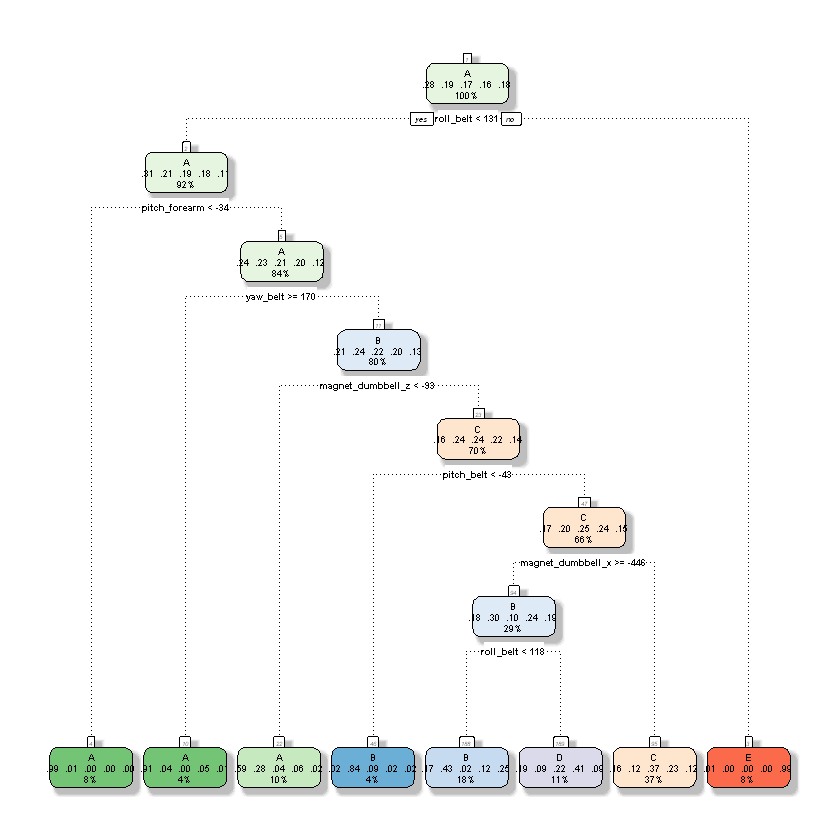

In [114]:
mdl_rpart = train(classe~., method = "rpart", data = training)
fancyRpartPlot(mdl_rpart$finalModel, sub="")